<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./212_ltpy_AC_SAF_GOME-2_L2_preprocess.ipynb"><< 212 - AC SAF - GOME-2 - Level 2 - Pre-process</a></span><span style="float:right;"><a href="./22_ltpy_AC_SAF_GOME-2_L3.ipynb">22 - AC SAF - GOME-2 - Level 3 data>></a></span>

# 2.1.3 IASI - Level 2 - Load and browse

The [Infrared Atmospheric Sounding Interferometer (IASI)](https://www.eumetsat.int/website/home/Satellites/CurrentSatellites/Metop/MetopDesign/IASI/index.html) is an intstrument onboard the Metop-A/B satellites. It provides information on the vertical structure of temperature and humidity as well as main atmospheric species.

IASI data are distributed via:
- the [EUMETSAT data centre (Earth Observation Portal)](https://eoportal.eumetsat.int/userMgmt/register.faces), and
- external services, e.g. [AERIS](https://www.aeris-data.fr/).

IASI Level 2 data are disseminated in `BUFR` originally. AERIS implemented the [IASI portal](https://iasi.aeris-data.fr/), which provides the data in `netCDF` format as well.

#### This module has the following outline:
* [1 - Load and browse IASI Level 2 data](#load)
* [2 - Mask IASI Level 2 data](#masking)
* [3 - Combine Metop-A/B IASI Level 2 data](#combine)

#### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, clear_output

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = FutureWarning)

#### Load helper functions

In [2]:
from ipynb.fs.full.ltpy_functions import visualize_l2, generate_xr_from_1D_vec, generate_masked_array

<hr>

## <a id="load"></a>Load and browse IASI Level 2 products

IASI Level 2 data from the [IASI portal](https://iasi.aeris-data.fr/) are disseminated in the `netCDF` format. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/index.html) to access and manipulate datasets in `netCDF` format.

The following examples shows an example of `Ammonia total column (NH`<sub>`3`</sub>`)`.

### Load netCDF data with `xarray`

`xarray`'s function `open_dataset` enables you to open a `netCDF` file. Once loaded, you can inspect the data structure of the `IASI` data disseminated by the IASI portal.

You see, that the data is a 1-dimensional vector with more than 630,000 individual data points. `latitude`, `longitude` and other parameters are stored as individual data variables.

In [3]:
file_name_2a = './eodata/iasi/nc/2a/2017/09/12/nh3nn_v2_2_20170912_AM.nc'
file_2a = xr.open_dataset(file_name_2a)
file_2a

<xarray.Dataset>
Dimensions:    (time: 632477)
Coordinates:
  * time       (time) float32 1951.6311 1951.6311 ... 235959.84 235959.84
Data variables:
    latitude   (time) float32 ...
    longitude  (time) float32 ...
    column     (time) float32 ...
    error      (time) float32 ...
    CLcov      (time) float32 ...
    VertProf   (time) int32 ...
    angle      (time) float32 ...
Attributes:
    Title:               Ammonia total columns retrieved from IASI measuremen...
    Institution:         Universite Libre de Bruxelles (ULB)/Laboratoire atmo...
    Product_Version:     v2.2
    keywords:            satellite, observation, atmosphere, ammonia
    date_created:        2018-06-13 01:11:30
    contact_emails:      Simon Whitburn (simon.whitburn@ulb.ac.be), Lieven Cl...
    platform:            Metop-A
    spatial_resolution:  12 km diameter pixel at nadir

### Generate a xarray  `DataArray` with latitude and longtiude as coordinates

With the help of the function [generate_xr_from_1D_vec](./ltpy_function.ipynb#generate_xr_from_1D_vec), you can generate a `xarray DataArray` object, with `latitude` and `longitude` values as coordinates and the `column` information as data values. This data structure will be helpful for plotting and masking the data.

In [4]:
nh3=file_2a['column']
nh3_da_2a = generate_xr_from_1D_vec(file_2a, 'latitude', 'longitude', nh3, 'nh3', file_2a.Title,1, 'mol/m-2')
nh3_da_2a

<xarray.DataArray 'nh3' (ground_pixel: 632477)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 67.73828 67.34395 ... 71.48293 71.3636
    longitude  (ground_pixel) float32 -94.98246 -95.7743 ... -96.48468 -95.85607
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Ammonia total columns retrieved from IASI measurements from t...
    units:      mol/m-2

### Visualize the IASI Level 2 data

The next step is to visualize the generated `xarray DataArray`. You can re-use the [visualize_l2](./ltpy_functions.ipynb#visualize_l2) function, that plots data points as a scatter plot.

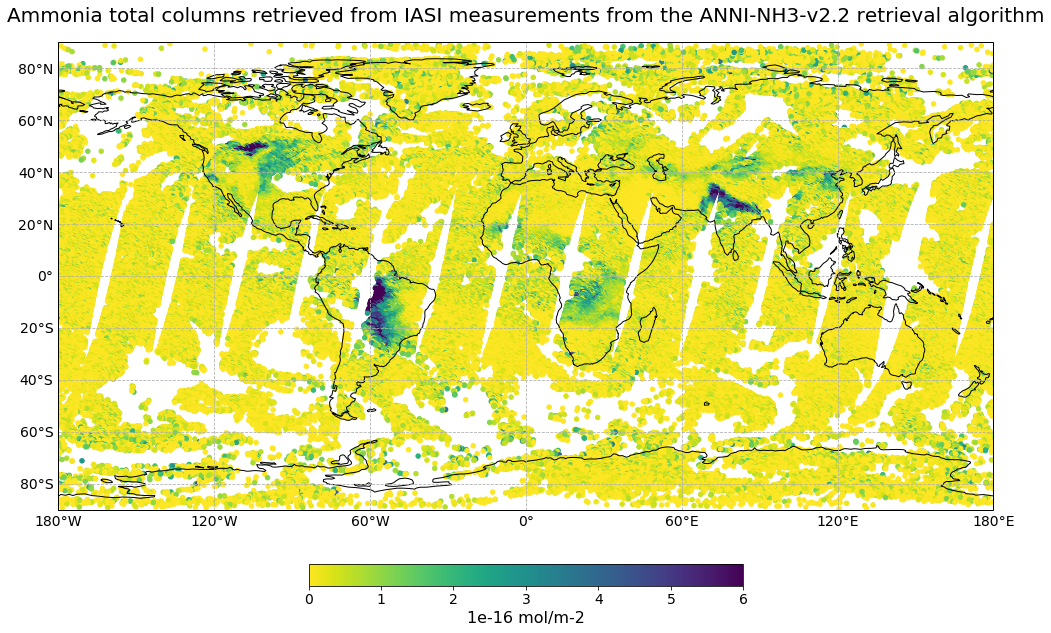

In [5]:
visualize_l2(nh3_da_2a, 1e-16, ccrs.PlateCarree(),0,6, 20,'viridis_r', nh3_da_2a.units, nh3_da_2a.long_name,set_global=True)

## <a id='masking'></a>Mask IASI Level 2 data products

The IASI Level data files provide you information on the Cloud Cover for each data point. This information is useful to generate a cloud mask and to mask out data points with a cloud cover exceeding a specific threshold.

In order to do so, you have to load the cloud cover information `CLcov` from the data file. You can re-use the [generate_xr_from_1D_vec](./ltpy_functions.ipynb#generate_xr_from_1D_vec) function again.

In [6]:
cloudCov = file_2a['CLcov']
nh3_mask_2a = generate_xr_from_1D_vec(file_2a, 'latitude', 'longitude', cloudCov, 'cloud_cover', 'Cloud Cover', 1, '%')
nh3_mask_2a

<xarray.DataArray 'cloud_cover' (ground_pixel: 632477)>
array([21.48, 32.59, 28.97, ..., 88.98, 80.07, 73.65], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 67.73828 67.34395 ... 71.48293 71.3636
    longitude  (ground_pixel) float32 -94.98246 -95.7743 ... -96.48468 -95.85607
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Cover
    units:      %

### Mask the `xarray DataArray` with the `generate_masked_array` function

The cloud cover information can now be used to mask the `xarray DataArray`. You can make use of the function [generate_masked_array](./ltpy_functions.ipynb#generate_masked_array), where you can set a threshold. All data points with a cloud coverage beyond this threshold are masked out.

You see that the number of data points reduced to just a bit more than 100,000 instead of more than 600,000. With the [visualize_l2](./ltpy_functions.ipynb#visualize_l2) function, you can visualize the masked array.

In [7]:
nh3_2a_masked = generate_masked_array(nh3_da_2a,nh3_mask_2a, 20, '<')
nh3_2a_masked

<xarray.DataArray (ground_pixel: 103272)>
array([9.8974161e+15, 1.8665552e+16, 8.7849626e+15, ..., 5.1941090e+14,
       8.4640888e+15, 9.9321484e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 68.43159 71.03365 ... 68.52289 68.37799
    longitude  (ground_pixel) float32 -99.99033 -97.56222 ... -94.52429
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Ammonia total columns retrieved from IASI measurements from t...
    units:      mol/m-2

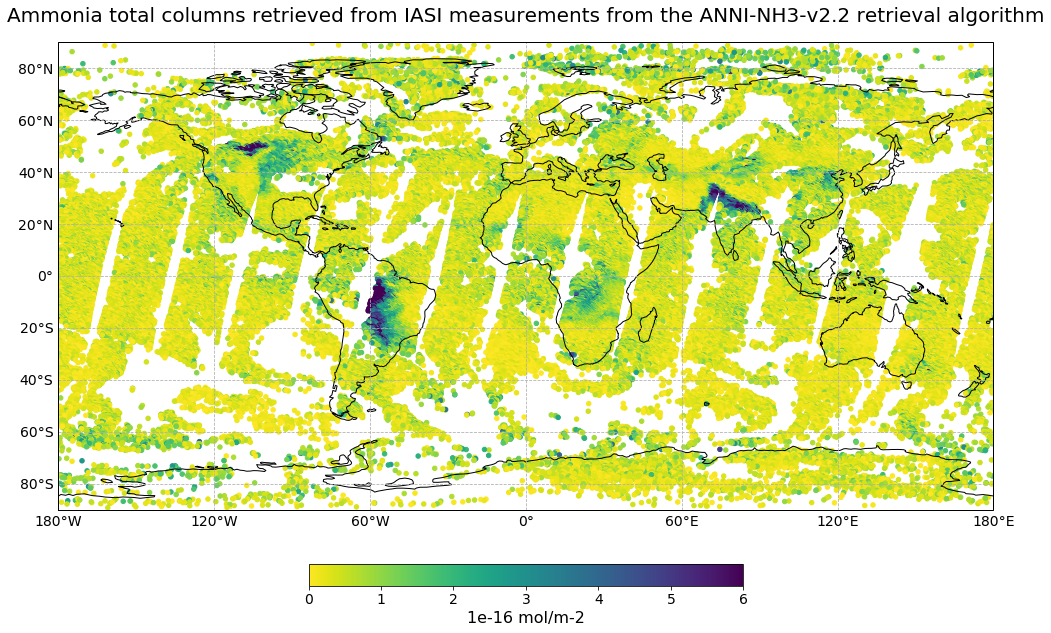

In [8]:
visualize_l2(nh3_2a_masked, 1e-16, ccrs.PlateCarree(),0,6,20,'viridis_r', nh3_2a_masked.units, nh3_2a_masked.long_name,set_global=True)

<br>

## <a id='combine'></a>Combine Metop A/B IASI Level 2 products

You can combine IASI Level 2 data from both satellites, Metop-A and Metop-B. You have to repeat all the steps you did for IASI Level 2 data from the Metop-A satellite above for the data from the Metop-B satellite.

The steps include:
- [1. Load the Metop-B IASI Level 2 data](#step1)
- [2. Generate a xarray DataArray with latitudes and longitudes as coordinates](#step2)
- [3. Load cloud cover information of the Metop-B IASI Level 2 data](#step3)
- [4. Generate a masked DataArray of the Metop-B IASI Level 2 data](#step4)

### Prepare Metop-B IASI Level 2 data

#### <a id='step1'></a>Load the Metop B IASI Level 2 data

In [9]:
file_name_2b = './eodata/iasi/nc/2b/2017/09/12/nh3nn_v2_2_20170912_AM.nc'
file_2b = xr.open_dataset(file_name_2b)
file_2b

<xarray.Dataset>
Dimensions:    (time: 652573)
Coordinates:
  * time       (time) float32 0.14901161 0.14901161 ... 235960.0 235960.0
Data variables:
    latitude   (time) float32 ...
    longitude  (time) float32 ...
    column     (time) float32 ...
    error      (time) float32 ...
    CLcov      (time) float32 ...
    VertProf   (time) int32 ...
    angle      (time) float32 ...
Attributes:
    Title:               Ammonia total columns retrieved from IASI measuremen...
    Institution:         Universite Libre de Bruxelles (ULB)/Laboratoire atmo...
    Product_Version:     v2.2
    keywords:            satellite, observation, atmosphere, ammonia
    date_created:        2018-06-12 21:40:52
    contact_emails:      Simon Whitburn (simon.whitburn@ulb.ac.be), Lieven Cl...
    platform:            Metop-B
    spatial_resolution:  12 km diameter pixel at nadir

#### <a id='step2'></a>Generate a xarray `DataArray` with latitude and longitude as coordinates

In [10]:
nh3=file_2b['column']
nh3_da_2b = generate_xr_from_1D_vec(file_2b, 'latitude', 'longitude', nh3, 'nh3', file_2b.Title, 1, 'mol/m-2')
nh3_da_2b

<xarray.DataArray 'nh3' (ground_pixel: 652573)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 9.30203 9.10344 ... -62.66393 -62.49234
    longitude  (ground_pixel) float32 138.30035 138.25795 ... 112.50047 112.7383
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Ammonia total columns retrieved from IASI measurements from t...
    units:      mol/m-2

#### <a id='step3'></a>Load cloud cover information of the Metop-B IASI Level 2 data

In [11]:
cloudCov = file_2b['CLcov']
nh3_mask_2b = generate_xr_from_1D_vec(file_2b, 'latitude', 'longitude', cloudCov, 'cloud_cover', 'Cloud Cover', 1, '%')
nh3_mask_2b

<xarray.DataArray 'cloud_cover' (ground_pixel: 652573)>
array([59.52, 50.45, 47.03, ..., 64.42, 68.59, 62.01], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 9.30203 9.10344 ... -62.66393 -62.49234
    longitude  (ground_pixel) float32 138.30035 138.25795 ... 112.50047 112.7383
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Cover
    units:      %

#### <a id='step4'></a>Generate a masked `DataArray` of the Metop-B IASI Level 2 data

In [12]:
nh3_2b_masked = generate_masked_array(nh3_da_2b,nh3_mask_2b, 0.2, '<')
nh3_2b_masked

<xarray.DataArray (ground_pixel: 80871)>
array([4.5823350e+15, 5.3689598e+15, 4.3748464e+15, ..., 9.1377543e+14,
       8.0592017e+15, 2.5474308e+16], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 9.80984 9.97181 ... -64.00939 -64.0653
    longitude  (ground_pixel) float32 134.33362 134.88019 ... 127.28312
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Ammonia total columns retrieved from IASI measurements from t...
    units:      mol/m-2

### Combine both NH<sub>3</sub> data arrays from Metop-A and Metop-B with `xarray.concat`

The last step is to concatenate both masked `DataArrays` from Metop-A and Metop-B into one single `DataArray`. You can use the function `xarray.concat` for it.

In [13]:
nh3_ab_da = xr.concat([nh3_2a_masked,nh3_2b_masked],dim='ground_pixel')
nh3_ab_da

<xarray.DataArray (ground_pixel: 184143)>
array([9.8974161e+15, 1.8665552e+16, 8.7849626e+15, ..., 9.1377543e+14,
       8.0592017e+15, 2.5474308e+16], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 68.43159 71.03365 ... -64.00939 -64.0653
    longitude  (ground_pixel) float32 -99.99033 -97.56222 ... 127.28312
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Ammonia total columns retrieved from IASI measurements from t...
    units:      mol/m-2

### Visualize the final combined masked IASI data with the `visualize_l2` function

Now you can visualize the combined and masked `DataArray`. You can re-use the function [visualize_l2](./ltpy_functions.ipynb#visualize_l2) data, which uses matplotlib's `scatterplot` function.

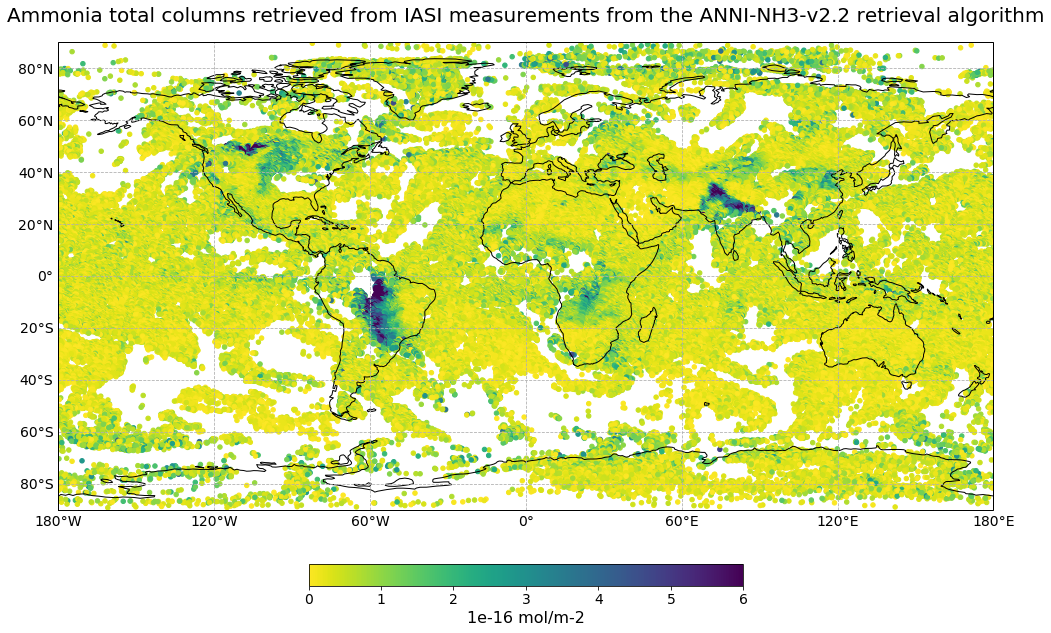

In [14]:
visualize_l2(nh3_ab_da, 1e-16, ccrs.PlateCarree(),0,6,20,'viridis_r', nh3_ab_da.units, nh3_ab_da.long_name, set_global=True)

<br>

<a href="./212_ltpy_AC_SAF_GOME-2_L2_preprocess.ipynb"><< 212 - AC SAF - GOME-2 - Level 2 - Pre-process</a></span><span style="float:right;"><a href="./22_ltpy_AC_SAF_GOME-2_L3.ipynb">22 - AC SAF - GOME-2 - Level 3 data>></a></span>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>